### Описание данных
* order_id - id заказа
* delivery_time - время доставки в минутах
* district - район доставки
* experiment_group - экспериментальная группа

### Сформулирую гипотезу
* H0: Разницы между средним временем доставки в тестовой и контрольной группе нет
* H1: Разница между средним временем доставки в тестовой и контрольной группе есть

In [5]:
import warnings
warnings.filterwarnings("ignore")

In [6]:
import numpy as np
import pandas as pd
import scipy.stats as st
import pingouin as pg

import seaborn as sns
import matplotlib.pyplot as plt

sns.set(rc={'figure.figsize':(12,6)}, style="whitegrid")

In [7]:
ab_test = pd.read_csv("https://getfile.dokpub.com/yandex/get/https://disk.yandex.ru/d/l7RSVjrz_a3GJg")
ab_test.head()

,order_id,delivery_time,district,experiment_group
0,3159,44.0,Purlieus,control
1,10426,51.0,Purlieus,control
2,9155,46.0,Purlieus,control
3,10699,34.0,Purlieus,control
4,10061,43.0,Purlieus,control


In [8]:
ab_test.shape

(20196, 4)

### 2. Сопоставим графики распределения и экспериментальные группы

In [9]:
sns.set(rc={'figure.figsize':(12,6)}, style="whitegrid")

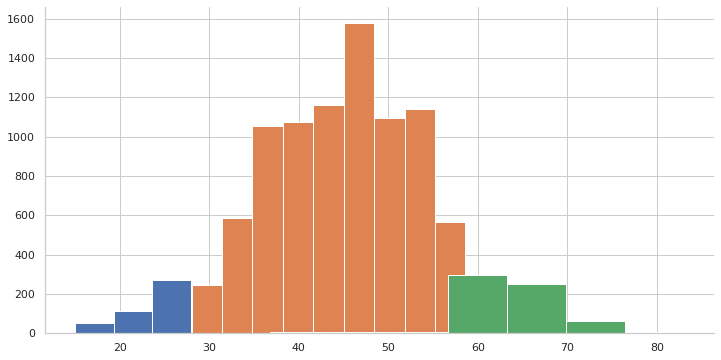

In [11]:
ab_test.query("experiment_group == 'control'").groupby('district').delivery_time.hist()
sns.despine()

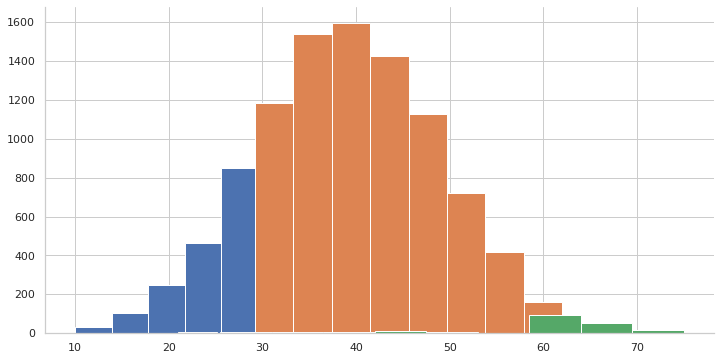

In [12]:
ab_test.query("experiment_group == 'test'").groupby('district').delivery_time.hist()
sns.despine()

### 3. Количество наблюдений в тестовой и контрольной группе

In [15]:
ab_test.groupby("experiment_group", as_index=False).agg({"district":"count"})

,experiment_group,district
0,control,10092
1,test,10104


Количество наблюдений отличается на 12 

### 4. Проверим выполнение условий на нормальность и посчитаем стандартное отклонение в тесте и в контроле.

In [18]:
#проверка на нормальность работает примерно так
#берём данные нужной нам группы

a_control = df.query("experiment_group == 'control'").delivery_time

#и кладём в функцию
stats.normaltest(a_control)

NormaltestResult(statistic=0.25349755437872584, pvalue=0.8809549607809654)

In [19]:
b_control = df.query("experiment_group == 'test'").delivery_time

#и кладём в функцию
stats.normaltest(b_control)

NormaltestResult(statistic=7.024157092641915, pvalue=0.02983483685333173)

Стандартное отклонение

In [22]:
ab_test.groupby("experiment_group").delivery_time.std()

experiment_group
control    9.990017
test       9.883308
Name: delivery_time, dtype: float64

Проверку на нормальность также сделаем на Шапиро с сэмплированием

In [26]:
st.shapiro(ab_test.query("experiment_group == 'test'").delivery_time.sample(1000, random_state=17))

ShapiroResult(statistic=0.9975479245185852, pvalue=0.14013493061065674)

In [24]:
st.shapiro(ab_test.query("experiment_group == 'control'").delivery_time.sample(1000, random_state=17))

ShapiroResult(statistic=0.9974725842475891, pvalue=0.12411931157112122)

Вариант с qq-плотами

<AxesSubplot:title={'center':'Q-Q Plot'}, xlabel='Theoretical quantiles', ylabel='Ordered quantiles'>

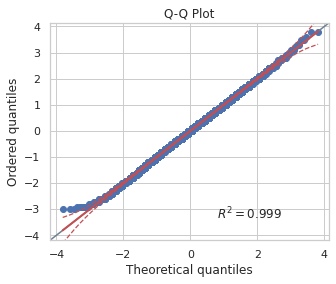

In [27]:
pg.qqplot(ab_test.query("experiment_group == 'control'").delivery_time)

Для того, чтобы проверить нормальность распределения, я использую SHAPIRO-WILK TEST. Этот тест показывает, что значения в тестовой группе распределены НОРМАЛЬНО. В контрольной группе распределение является НОРМАЛЬНЫМ. Стандартное отклонение времени доставки в тесте равно 9.88. Стандартное отклонение времени доставки в контроле равно 9.99.

### 5. Сравним средние в тесте и контроле

In [29]:
ttest_ind(df[df.experiment_group == 'test'].delivery_time,
          df[df.experiment_group == 'control'].delivery_time)

Ttest_indResult(statistic=-43.03582663183714, pvalue=0.0)

In [30]:
#scipy

st.ttest_ind(a=ab_test.query("experiment_group == 'test'").delivery_time, 
             b=ab_test.query("experiment_group == 'control'").delivery_time, equal_var=True)

Ttest_indResult(statistic=-43.03582663183714, pvalue=0.0)

In [31]:
#pingouin

pg.ttest(x=ab_test.query("experiment_group == 'test'").delivery_time, 
         y=ab_test.query("experiment_group == 'control'").delivery_time)

,T,dof,alternative,p-val,CI95%,cohen-d,BF10,power
T-test,-43.035552,20191.127788,two-sided,0.0,"[-6.29, -5.74]",0.605658,inf,1.0


Для сравнения средних в данных экспериментальных группах я использовала STUDENT'S T-TEST. Статистика в тесте равна -43, p-value <= 0.05.

In [32]:
#попробую для сравнения Манна-Уитни
#scipy

st.mannwhitneyu(x=ab_test.query("experiment_group == 'test'").delivery_time, 
                y=ab_test.query("experiment_group == 'control'").delivery_time)

MannwhitneyuResult(statistic=33985060.0, pvalue=0.0)

In [33]:
#pingouin

pg.mwu(x=ab_test.query("experiment_group == 'test'").delivery_time, 
       y=ab_test.query("experiment_group == 'control'").delivery_time)

,U-val,alternative,p-val,RBC,CLES
MWU,33985060.0,two-sided,0.0,0.333427,0.333286


### 6. Посчитаю на сколько процентов изменилось среднее время доставки в тестовой группе по сравнению с контрольной

In [34]:
mean_test = ab_test.query("experiment_group == 'test'").delivery_time.mean()
mean_control = ab_test.query("experiment_group == 'control'").delivery_time.mean()

In [35]:
(1 - (mean_test / mean_control)) * 100

13.354653121660808

### Вывод
**Да, раскатываем новый алгоритм на всех, так как среднее время доставки статистически значимо изменилось. Среднее время доставки в тесте меньше, чем в контроле.**